### **Introduction**


This project focuses on the **training of a Convolutional Neural Network (CNN) and its ability to categorise the breed of a pet using the Oxford-IIIT Pet Dataset.** The dataset includes pictures of cats and dogs of 37 various breeds, so the database is rather useful in training of models that are intended to be used in the recognition of pets.

The first one is to train from the raw data a baseline CNN this model allows having an initial conception about the process of image classification. The first model works as reference performance shows the obstacle and constrain of applying simple CNN architecture on complicated dataset.

To improve the model performance to the best extent possible, we then use **Transfer Learning with EfficientNet B2**, which is one of the most efficient and high performing architectures for the tasks of computer vision. Given a network we start with, we adopt a pre-trained EfficientNet B2 model, and further train the model for the purpose of pet breed categorization. This greatly enhances the models capability since the pre-trained network is not only able to identify deeper characteristics about the images.

This way for the given task it will be shown how much the transition from a simple CNN to transfer learning and from there to more complex EfficientNet B2 model may improve both accuracy and the models ability to generalize.

In [25]:
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
# Import matplotlib for visualization
import os  # For interacting with the operating system
from PIL import Image  # For handling image files
from timeit import default_timer as timer
import shutil
from pathlib import Path


import torchvision.models as models
import matplotlib.pyplot as plt

In [26]:
#The device agnostic code to check if a GPU is availble or else continue with a CPU

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [27]:
# Using transform.compose to convert the images into a widely accepted size and into a pytorch tensor

Transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

### Creating a dataset object for the Oxford-IIIT Pet Dataset using PyTorch's datasets.OxfordIIITPet class. To see more about the dataset please visit the link [OxfordIIITPet Dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html)

In [28]:
train_data=datasets.OxfordIIITPet(root='data', #Downloads the data into root directory
                                     split = 'trainval', #The dataset has predefined splits for training, validation, and testing
                                     download = True,
                                     transform=Transform,
                                     target_transform = None
                                     )

In [29]:
# datapath = Path("/content/data")
# datapath

In [30]:
 len(train_data)

3680

In [31]:
# Creating dictionaries of class name, its index and index and class name


class_to_idx = train_data.class_to_idx

# Invert the dictionary to get index to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

class_dict =train_data.class_to_idx
class_dict

{'Abyssinian': 0,
 'American Bulldog': 1,
 'American Pit Bull Terrier': 2,
 'Basset Hound': 3,
 'Beagle': 4,
 'Bengal': 5,
 'Birman': 6,
 'Bombay': 7,
 'Boxer': 8,
 'British Shorthair': 9,
 'Chihuahua': 10,
 'Egyptian Mau': 11,
 'English Cocker Spaniel': 12,
 'English Setter': 13,
 'German Shorthaired': 14,
 'Great Pyrenees': 15,
 'Havanese': 16,
 'Japanese Chin': 17,
 'Keeshond': 18,
 'Leonberger': 19,
 'Maine Coon': 20,
 'Miniature Pinscher': 21,
 'Newfoundland': 22,
 'Persian': 23,
 'Pomeranian': 24,
 'Pug': 25,
 'Ragdoll': 26,
 'Russian Blue': 27,
 'Saint Bernard': 28,
 'Samoyed': 29,
 'Scottish Terrier': 30,
 'Shiba Inu': 31,
 'Siamese': 32,
 'Sphynx': 33,
 'Staffordshire Bull Terrier': 34,
 'Wheaten Terrier': 35,
 'Yorkshire Terrier': 36}

In [32]:
# Checking a random image i.e. the 2222th image to check its label index, label name and the shape as a tensor. Pytorch expects channels first and them height and width i.e. 3X224X224

image,label =train_data[2222]

label,idx_to_class[label],image.shape

(7, 'Bombay', torch.Size([3, 224, 224]))

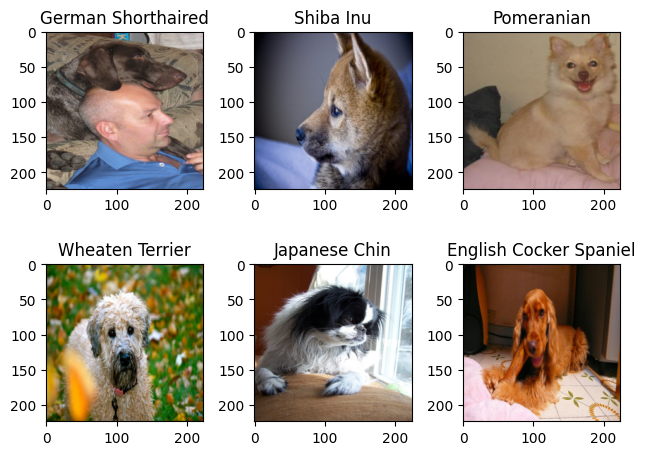

In [33]:
# Plotting six random image from the dataset using torch.randint function with its classs


for i in range(6):
  j=torch.randint(0, len(train_data), size = [1]).item()
  image, label = train_data[j]
  plt.subplot(2,3, i+1)
  plt.imshow(image.numpy().transpose((1,2,0)))
  plt.title(idx_to_class[label])

plt.tight_layout()
plt.show()


In [34]:
#Using the pytorch DataLoader function shuffling the data with each batch containing 32 images

train = DataLoader(dataset = train_data,
                   batch_size = 32,

                   shuffle = True)

In [35]:
image, label = next(iter(train))
image.shape, label

(torch.Size([32, 3, 224, 224]),
 tensor([31, 32, 27, 36,  0, 35,  0, 33,  8,  7, 29,  6,  0, 34,  8,  3, 19, 19,
         25, 21,  8,  1,  7, 13, 16, 14, 35, 24, 13, 24, 18, 36]))

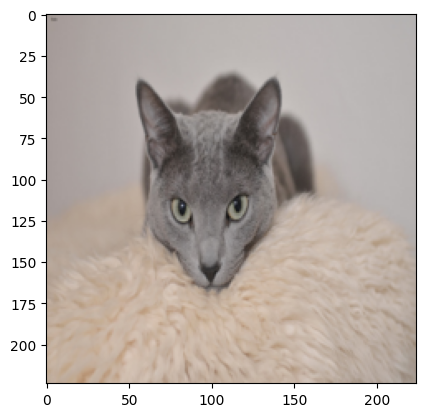

In [36]:
# Checking the image with altering the dimensions using transpose() as matplotlib expects a numpy array of shape height X width X channels

plt.imshow(image[2].numpy().transpose((1,2,0)))



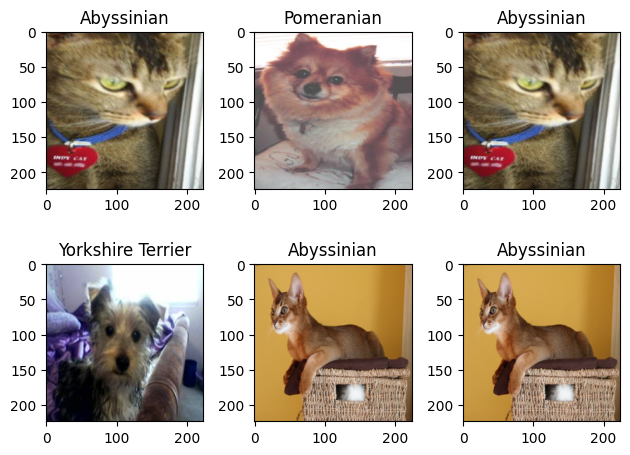

In [37]:
#Plotting random image from dataloader batch which was obtained from next(iter(train)) function

for i in range(6):
  j=torch.randint(0,len(image), size= [1]).item()
  plt.subplot(2,3, i+1)
  plt.imshow(image[j].numpy().transpose((1,2,0)))
  plt.title(idx_to_class[label[j].item()])


plt.tight_layout()
plt.show()

In [38]:
# Creating the test data

test_data = datasets.OxfordIIITPet(root='data',
                                     split = 'test',
                                     download = True,
                                     transform=Transform,
                                     target_transform = None
                                     )

test = DataLoader(dataset = test_data,
                  batch_size = 32,
                  shuffle = False)

In [39]:
test_images, test_labels = next(iter(test))

In [40]:
test_images.shape, label, len(test), len(train)

(torch.Size([32, 3, 224, 224]),
 tensor([31, 32, 27, 36,  0, 35,  0, 33,  8,  7, 29,  6,  0, 34,  8,  3, 19, 19,
         25, 21,  8,  1,  7, 13, 16, 14, 35, 24, 13, 24, 18, 36]),
 115,
 115)

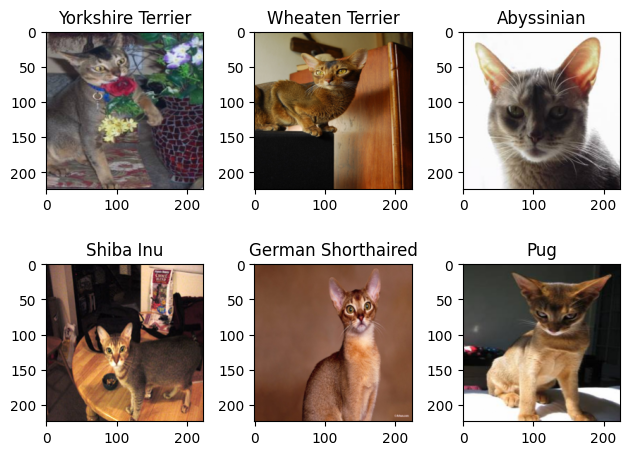

In [41]:
# Plotting random test images

for i in range(6):
  j=torch.randint(0, len(test_images), size =[1]).item()
  plt.subplot(2,3,i+1)
  plt.imshow(test_images[j].numpy().transpose((1,2,0)))
  plt.title(idx_to_class[label[j].item()])

plt.tight_layout()
plt.show()



*   
Below we make a simple Convolutional Neural Network (CNN) model using PyTorch's
nn.Module class. The network consists of three convolutional layers (conv1, conv2, conv3), each followed by a ReLU activation function and a MaxPooling layer to reduce the spatial dimensions of the input. The first convolutional layer takes 3 input channels (for RGB images) and outputs 10 feature maps. The second layer takes these 10 feature maps and processes them into 10 new feature maps, while the third layer increases this to 20 feature maps. After the convolutional layers, the output is flattened and passed through a fully connected classifier consisting of two linear layers with ReLU activation in between, eventually outputting 37 classes, which corresponds to the 37 pet breeds in the Oxford-IIIT Pet Dataset.






In [42]:
class cnn_model(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1=nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 10,
                  kernel_size = 3,
                  stride = 1, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride =2)
    )

    self.conv2=nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels =10,
                  kernel_size=5,
                  stride=2, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride =2)
    )
    self.conv3=nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels =20,
                  kernel_size=5,
                  stride=2, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride =2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        # nn.Linear(in_features = 980, out_features=245),
        nn.Linear(in_features=720, out_features=245),
        nn.ReLU(),
        nn.Linear(in_features=245, out_features = 37)
    )

  def forward(self,x):
    x=self.classifier(self.conv3(self.conv2(self.conv1(x))))
    return x

In [43]:
model = cnn_model().to(device)
model

cnn_model(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=720, out_features=245, bias=True)
    (2): ReLU()
    (3): Linear(in_features=245, out_features=37, bias=True)
  )
)

Installing Torchinfo for the summary of the model

In [44]:
!pip install torchinfo
from torchinfo import summary

In [45]:
summary(model = model,
        input_size = (1,3,224,224),
        col_width=20,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        )

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
cnn_model                                [1, 3, 224, 224]     [1, 37]              --                   True
├─Sequential: 1-1                        [1, 3, 224, 224]     [1, 10, 111, 111]    --                   True
│    └─Conv2d: 2-1                       [1, 3, 224, 224]     [1, 10, 222, 222]    280                  True
│    └─ReLU: 2-2                         [1, 10, 222, 222]    [1, 10, 222, 222]    --                   --
│    └─MaxPool2d: 2-3                    [1, 10, 222, 222]    [1, 10, 111, 111]    --                   --
├─Sequential: 1-2                        [1, 10, 111, 111]    [1, 10, 27, 27]      --                   True
│    └─Conv2d: 2-4                       [1, 10, 111, 111]    [1, 10, 54, 54]      2,510                True
│    └─ReLU: 2-5                         [1, 10, 54, 54]      [1, 10, 54, 54]      --                   --
│    └─MaxPool2d: 2-

In [46]:
# Choosing the loss function as Cross Entropy and Optimizer as ADAM

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001)

In [47]:
epochs = 10

for epoch in range(epochs):
  train_loss=0
  for batch, (X, y) in enumerate(train):
    X=X.to(device)
    y=y.to(device)

    model.train()

    y_preds=model(X)

    loss = loss_fn(y_preds,y)

    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss/= len(train)


  test_loss= 0
  correct = 0
  total = 0
  test_pred_list = []
  all_preds = []
  all_labels = []

  model.eval()
  with torch.inference_mode():

    for x_test, y_test in test:

      x_test,y_test = x_test.to(device), y_test.to(device)

      ytestpreds = model(x_test)

      loss_t = loss_fn(ytestpreds, y_test)

      test_loss += loss_t.item()

      _, predicted = torch.max(ytestpreds, 1)

      correct += (predicted == y_test).sum().item()

      total += y_test.size(0)

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(y_test.cpu().numpy())

    test_loss /= len(test)
    accuracy = (correct/total)*100

  print(f"Epochs : {epoch}||| train loss : {train_loss}||| test loss {test_loss}||| Accuracy = {accuracy}")


Epochs : 0||| train loss : 3.610159523590751||| test loss 3.6045612024224325||| Accuracy = 3.5704551648950664
Epochs : 1||| train loss : 3.573139696535857||| test loss 3.510673359166021||| Accuracy = 6.241482692831834
Epochs : 2||| train loss : 3.410685151556264||| test loss 3.440973356495733||| Accuracy = 8.013082583810302
Epochs : 3||| train loss : 3.3164918464163073||| test loss 3.3978302126345428||| Accuracy = 8.994276369582993
Epochs : 4||| train loss : 3.2620734836744227||| test loss 3.388263393485028||| Accuracy = 8.503679476696648
Epochs : 5||| train loss : 3.211585111203401||| test loss 3.3806900750035824||| Accuracy = 9.239574816026165
Epochs : 6||| train loss : 3.161549808668054||| test loss 3.370267803772636||| Accuracy = 9.348596347778686
Epochs : 7||| train loss : 3.1169284426647685||| test loss 3.3530214288960334||| Accuracy = 9.811937857726901
Epochs : 8||| train loss : 3.0639834051546844||| test loss 3.3292274143384852||| Accuracy = 10.65685472880894
Epochs : 9||| trai

As we can see above the model performs very poorly even though it is a very shallow network. There is very small improvement in training loss, and hence this calls for a much deeper model.

**Transfer learning** is a machine learning technique where a pre-trained model, developed for a specific task, is adapted for a new but related task. Instead of training a model from scratch, which requires large amounts of data and computational resources, transfer learning leverages the knowledge the model has already gained (such as recognizing basic image features) and fine-tunes it for the new task. This often leads to faster training and better performance

**EfficientNet B2** is a variant of the EfficientNet family of models, which are known for their efficiency in terms of both speed and accuracy. EfficientNet models scale up the network's depth, width, and resolution in a balanced way, leading to better performance with fewer parameters compared to traditional models. B2 specifically refers to a particular scaling configuration that provides a good balance between accuracy and efficiency.

Using EfficientNet B2 for transfer learning is often more effective than creating a CNN from scratch because it starts with a model that has already learned rich feature representations from a large and diverse dataset like the ImageNet dataset. This allows for better generalization and faster convergence, making it ideal for tasks like identifying pet breeds in the Oxford-IIIT Pet Dataset.

In [48]:
#Initializing the EfficientNet b2 model and downloading its weight

weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model2 = torchvision.models.efficientnet_b2(weights=weights)
model2 = model2.to(device)
model2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# Initializing the transform on the dataset the same way that Efficientnet B2 was orignally trained on ie size of 288X288 and its normalization

In [49]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [50]:
# USing datasets and dataloaders again with auto_transform

train_data2=datasets.OxfordIIITPet(root='data',
                                     split = 'trainval',
                                     download = True,
                                     transform=auto_transforms,
                                     target_transform = None
                                     )

train2 = DataLoader(dataset = train_data2,
                   batch_size = 32,

                   shuffle = True)

In [51]:
image, label = next(iter(train2))
image.shape, label

(torch.Size([32, 3, 288, 288]),
 tensor([10, 35, 21, 34,  0, 21,  1, 17,  9, 13, 25, 10, 33, 33, 19, 36, 18, 18,
         10, 29,  3, 29, 11,  8, 13, 23, 23, 27, 34, 22, 29, 13]))

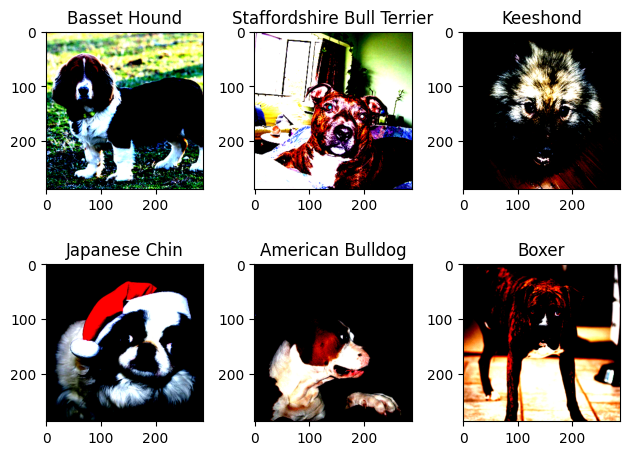

In [52]:
#Plotting random image from dataloader batch which was obtained from next(iter(train)) function

for i in range(6):
  j=torch.randint(0,len(image), size= [1]).item()
  plt.subplot(2,3, i+1)
  plt.imshow(image[j].numpy().transpose((1,2,0)))
  plt.title(idx_to_class[label[j].item()])


plt.tight_layout()
plt.show()

In [53]:
test_data2 = datasets.OxfordIIITPet(root='data',
                                     split = 'test',
                                     download = True,
                                     transform=auto_transforms,
                                     target_transform = None
                                     )




In [54]:
test2 = DataLoader(dataset = test_data2,
                  batch_size = 32,
                  shuffle = False)

In [55]:
test_images, test_labels = next(iter(test2))


In [56]:
test_images.shape, test_labels, len(test2)

(torch.Size([32, 3, 288, 288]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 115)

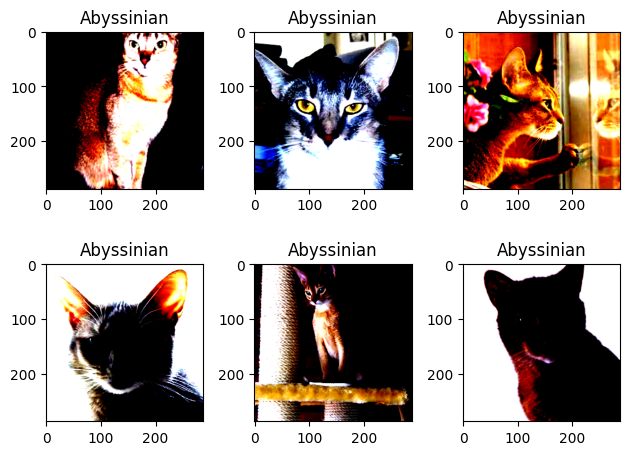

In [57]:
#Plotting random image from dataloader batch which was obtained from next(iter(test2)) function

for i in range(6):
  j=torch.randint(0, len(test_images), size =[1]).item()
  plt.subplot(2,3,i+1)
  plt.imshow(test_images[j].numpy().transpose((1,2,0)))
  plt.title(idx_to_class[test_labels[j].item()])

plt.tight_layout()
plt.show()

In the code below, params.requires_grad = False disables the gradient calculation for these parameters. As a result, when we call optimizer.step() during training, these parameters won't be updated.

In transfer learning, it's common to use a pre-trained model (like EfficientNet, ResNet, etc.) and only fine-tune the later layers or the classifier part of the model, while keeping the earlier layers frozen. Freezing these layers means their weights won’t be updated during backpropagation, which helps in retaining the learned features from the pre-trained model

In [58]:
for params in model2.features.parameters():
    params.requires_grad = False

The code below replaces the orignal classifier layer with a new custom classifier. The classifier is designed to take the feature representations learned by the pre-trained layers and map them to the desired output classes in this case, 37 classes corresponding to the 37 breeds in the Oxford-IIIT Pet Dataset.

In [59]:
model2.classifier = nn.Sequential(
    # nn.Dropout(p=0.2, inplace = True),
    nn.Linear(in_features = 1408, out_features = 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.2, inplace = False),
    nn.Linear(in_features=512, out_features = 256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features = 37)
).to(device)

model2.classifier

Sequential(
  (0): Linear(in_features=1408, out_features=512, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=37, bias=True)
)

In [60]:
summary(model = model2,
        input_size = (1,3,288,288),
        col_width=20,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        )

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [1, 3, 288, 288]     [1, 37]              --                   Partial
├─Sequential: 1-1                                       [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d: 3-1                                 [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU: 3-3                                   [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential: 2-2                                  [1, 32, 144, 144]    [1, 16, 144, 144]    --                   Fal

As we can see above, only the linear layers after flattened are trainable and outputs 37 features for a softmax function

Below model weights are being uploaded from a same code that i trained the model for 25 epochs and the weights were saved as"efficientnet_b2.pth" because of lack of availibility of GPU time

In [61]:
model =model2



In [62]:
# The model was previously trained for 50 epochs and the weights were saved as"efficientnet_b2.pth" because of lack of availibility of GPU time

model.load_state_dict(torch.load('efficientnet_b2.pth'))

<All keys matched successfully>

In [64]:
epochs = 5

for epoch in range(epochs):
  train_loss=0
  for batch, (X, y) in enumerate(train2):
    X=X.to(device)
    y=y.to(device)

    model.train()

    y_preds=model(X)

    loss = loss_fn(y_preds,y)

    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss/= len(train2)


  test_loss= 0
  correct = 0
  total = 0
  test_pred_list = []
  all_preds = []
  all_labels = []

  model.eval()
  with torch.inference_mode():

    for x_test, y_test in test2:

      x_test,y_test = x_test.to(device), y_test.to(device)

      ytestpreds = model(x_test)

      loss_t = loss_fn(ytestpreds, y_test)

      test_loss += loss_t.item()

      _, predicted = torch.max(ytestpreds, 1)

      correct += (predicted == y_test).sum().item()

      total += y_test.size(0)

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(y_test.cpu().numpy())

    test_loss /= len(test2)
    accuracy = (correct/total)*100

  print(f"Epochs : {epoch}||| train loss : {train_loss}||| test loss {test_loss}||| Accuracy = {accuracy}")

Epochs : 0||| train loss : 0.07363333025056383||| test loss 0.31796476613811175||| Accuracy = 90.21531752521122
Epochs : 1||| train loss : 0.0744869350415209||| test loss 0.3163082165522096||| Accuracy = 90.40610520577815
Epochs : 2||| train loss : 0.06886811218345942||| test loss 0.3244114680539655||| Accuracy = 90.16080675933496
Epochs : 3||| train loss : 0.0749303126545704||| test loss 0.3200858335253661||| Accuracy = 90.02452984464432
Epochs : 4||| train loss : 0.07115072031383929||| test loss 0.3240781490002637||| Accuracy = 90.07904061052058


The model currently achieves an impressive accuracy of nearly 90% on the test dataset, but despite a consistent reduction in training loss, the test loss suggests there's still room for improvement. To further enhance the model's performance, it's crucial to identify the specific labels where it struggles. By plotting a confusion matrix for all labels, we can pinpoint the areas where the model's predictions are less accurate and focus on those for improvement.

In [65]:
class_names = [None] * len(class_dict)
for name, index in class_dict.items():
    class_names[index] = name

class_names

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

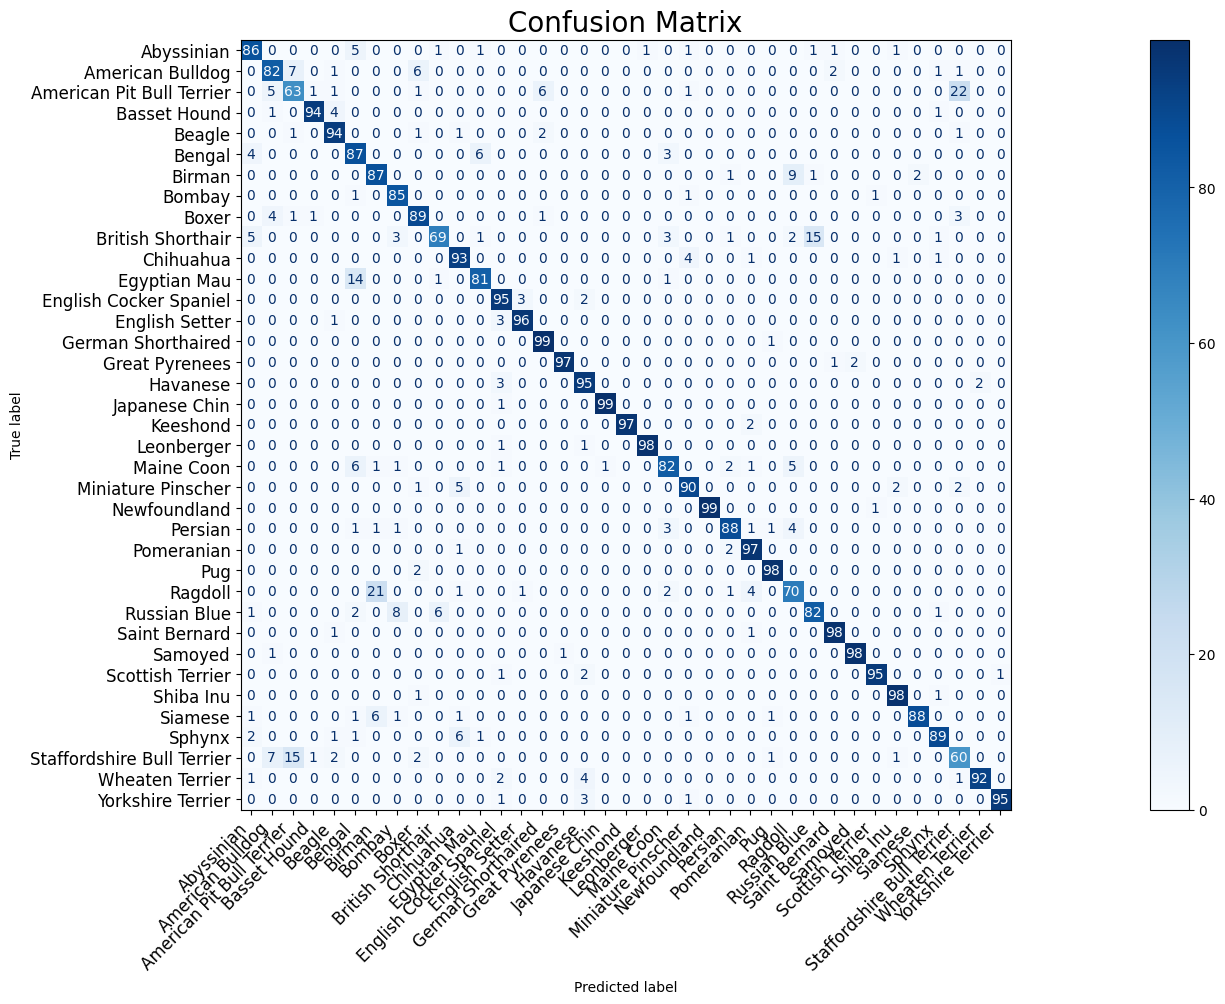

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Increase the figure size
plt.figure(figsize=(36, 10))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())

# Rotate the x-axis labels and adjust the font size
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.title("Confusion Matrix", fontsize=20)
plt.show()

In [67]:
torch.save(model.state_dict(), 'efficientnet_b2.pth')

It is obvious from the confusion matrix that the class on which the model performs the worse are 'american_pit_bull_terrier', 'staffordshire_bull_terrier'. Lets plot some of those and see if human eye can distinguish.

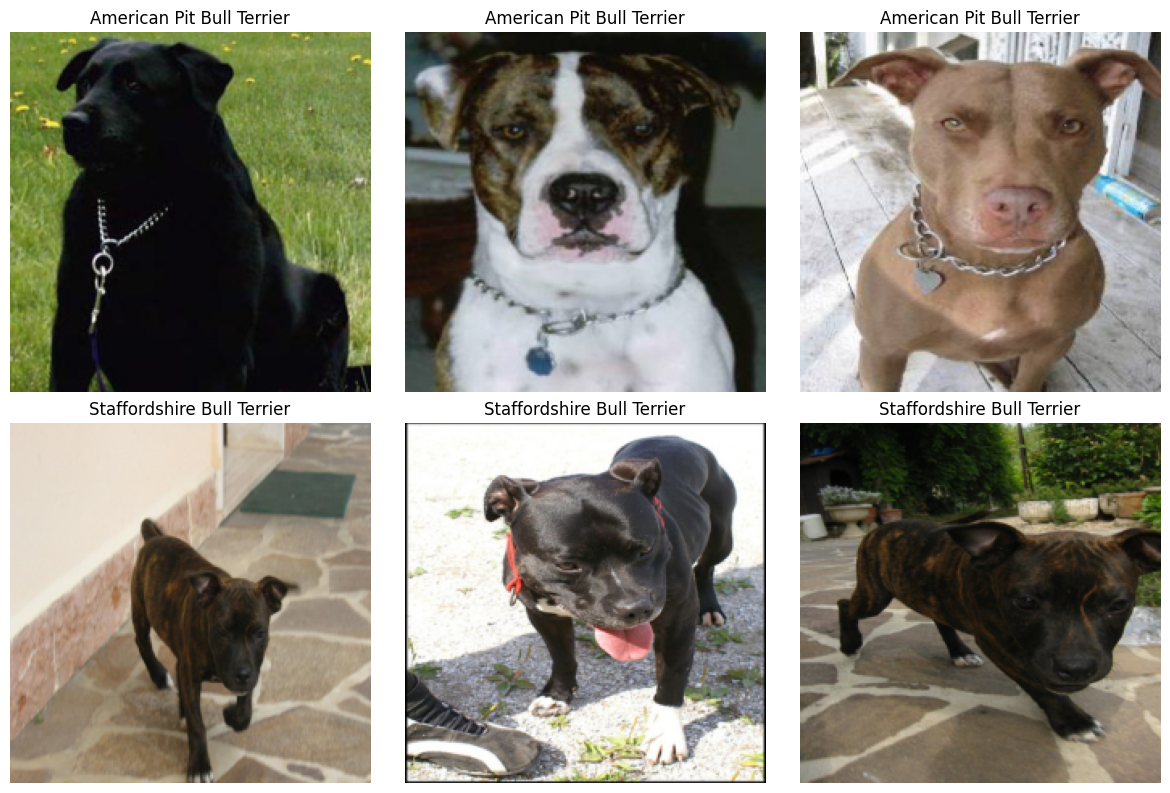

In [68]:
# Define the target classes
target_classes = ['american_pit_bull_terrier', 'staffordshire_bull_terrier']

# Create a dictionary to hold the images and their labels
images_to_plot = {cls: [] for cls in target_classes}
train_counts = {cls: 0 for cls in target_classes}

# Gather test images for plotting
for img, label in test_data:
    class_name = test_data.classes[label].lower().replace(' ', '_')
    if class_name in target_classes and len(images_to_plot[class_name]) < 3:
        images_to_plot[class_name].append(img)

# Count the number of training examples for each class
for img, label in train_data:
    class_name = train_data.classes[label].lower().replace(' ', '_')
    if class_name in target_classes:
        train_counts[class_name] += 1

# Plot the images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, (cls, images) in enumerate(images_to_plot.items()):
    for j, img in enumerate(images):
        axes[i * 3 + j].imshow(img.permute(1, 2, 0))
        axes[i * 3 + j].set_title(cls.replace('_', ' ').title())
        axes[i * 3 + j].axis('off')

plt.tight_layout()
plt.show()

# # Print the number of training examples
# for cls, count in train_counts.items():
#     print(f'Number of training examples for {cls.replace("_", " ").title()}: {count}')

### **Conclusion**

As we can see above, they are very similar and to improve on this class we can use more images from these class, specially images capturing the information on size of their body to get a better accuracy.


**To improve the overall performence, we can use:**

*   **Augmentation**: Apply data augmentation techniques such as random cropping, rotation, flipping, and color jittering to increase the variability of images, which can help the model generalize better.

*   **Fine-Tuning the Model**: which is changing the hyperparameters such as training for more epochs, altering the learning rate etc or even unfreezing some of the earlier layers could make a difference. The model could also be concluded to be slighly overfitting so theoratically adding more data, inducing more regularization could also help.

*   **Using complex architecture**: Using further complex architectures like Ensemble methods, which combine predictions from multiple models. For example, use an ensemble of EfficientNet with other architectures like ResNet or DenseNet. Or using Attention machenism such as Visual Transformers.

*   **Class-Specific Data Enhancement**:Identify images where the model consistently makes errors like the class of 'British Short Hair', 'Ragdoll' and specifically target these for additional training or use techniques like focal loss, which focuses on hard-to-classify examples. Focal Loss modifies the Cross-Entropy Loss by adding a factor that gives less weight to well-classified examples (easy examples) and more weight to misclassified examples (hard examples). This helps the model focus more on learning from the hard examples that it struggles with. bold text **bold text**




______________________________________________________________________________________________________________________________________________________________________

**We will use Gradio demo to deploy this model for a web browser.**

Gradio provides a simple and user-friendly interface to deploy machine learning models as web applications, allowing users to interact with your model directly through their browser. In this demonstration, we will deploy a pet breed detection model trained on the Oxford-IIIT Pet Dataset using EfficientNet-B2 architecture.

The deployment will allow users to upload images of pets and get predictions in real-time, including the top 3 breed predictions with their associated probabilities.

Gradio enables us to create a shareable link for our application, making it easy to share the model with others or integrate it into larger systems.

In [69]:
import os  # For interacting with the operating system
from PIL import Image  # For handling image files


In [70]:
# Create a function that transforms the image the same way our model expects and also using the unsqueeze function to give a mimic batch dimension to the image

def image_transform(img):
    # sample_img =Image.open(img)
    sample_img=auto_transforms(img).unsqueeze(0)

    return sample_img



In [71]:
from timeit import default_timer as timer

In [72]:
#Since we will have a CPU and not a GPU in the Demo
gradio_model = model.to("cpu")

In [73]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.8 MB/s eta 0:00:00
Gradio version: 4.41.0


In [74]:
def predict(image):

    start_time = timer() #To clock the time taken for prediction

    image = image_transform(image) #transform the image

    gradio_model.eval()
    with torch.inference_mode():
        pred = torch.softmax(gradio_model(image), dim = 1)

    # pred_labels_and_probs = {class_names[i]: float(pred[0][i]) for i in range(len(class_names))}

    top_probs, top_indices = torch.topk(pred, 3, dim=1) # Get the top 3 probabilities and their indices

    # Create the dictionary with the top 3 labels and their probabilities
    pred_labels_and_probs = {
        class_names[top_indices[0][i]]: float(top_probs[0][i])
        for i in range(3)}

    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    return pred_labels_and_probs, pred_time





In [75]:
# predict("/content/data/oxford-iiit-pet/images/Bengal_89.jpg")

In [76]:
example_list = [["/content/data/oxford-iiit-pet/images/British_Shorthair_44.jpg"],
                ["/content/data/oxford-iiit-pet/images/Abyssinian_98.jpg"],
                ["/content/data/oxford-iiit-pet/images/Bengal_89.jpg"]]

example_list

[['/content/data/oxford-iiit-pet/images/British_Shorthair_44.jpg'],
 ['/content/data/oxford-iiit-pet/images/Abyssinian_98.jpg'],
 ['/content/data/oxford-iiit-pet/images/Bengal_89.jpg']]

In [ ]:
title = "The Pets Breed Detector"
desc = "The Pets Breed Detector uses Efficientb2 style convolution neural network, which is trained to identify 37 of the most common breeds of cats and dogs often chosen as domestic pets "
article = "A Feature Extractor CNN Model by Anand Jaiswal "

demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=desc,
                    article=article)

# Launch the demo
demo.launch(debug=True, # print errors locally?
            share=True) # generate a publically shareable URL

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2301352468ebf6da78.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
